# Model set-up to simulate apparent thickness likelihood at drillhole location

In [1]:
from IPython.core.display import HTML
css_file = 'pynoddy.css'
HTML(open(css_file, "r").read())

In [2]:
import sys, os
import matplotlib.pyplot as plt
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
repo_path = os.path.realpath('../..')
import pynoddy.history
import numpy as np

In [3]:
%matplotlib inline

In [4]:
# Combined: model generation and output vis to test:
history = "simple_model.his"
output_name = "simple_out"
#
# A general note: the 'reload' statements are only important
# for development purposes (when modules were chnaged), but not
# in required for normal execution.
#
reload(pynoddy.history)
reload(pynoddy.events)

# create pynoddy object
nm = pynoddy.history.NoddyHistory()
# add stratigraphy
strati_options = {'num_layers' : 8,
                  'layer_names' : ['layer 1', 'layer 2', 'layer 3', 
                                   'layer 4', 'layer 5', 'layer 6', 
                                   'layer 7', 'layer 8'],
                  'layer_thickness' : [1500, 500, 500, 500, 500, 500, 500, 500]}
nm.add_event('stratigraphy', strati_options )

nm.write_history(history)



In [5]:
# Compute the model
reload(pynoddy)
pynoddy.compute_model(history, output_name) 

''

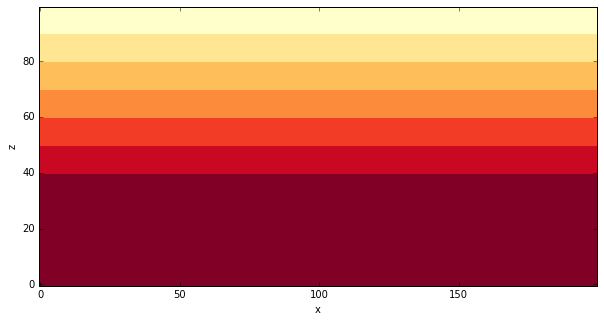

In [6]:
# Plot output
import pynoddy.output
reload(pynoddy.output)
nout = pynoddy.output.NoddyOutput(output_name)
nout.plot_section('y', layer_labels = strati_options['layer_names'][::-1], 
                  colorbar = True, title="",
                  savefig = False, fig_filename = "ex01_strati.eps")

## Import in Experiment object

In [7]:
reload(pynoddy.history)
reload(pynoddy.events)
import pynoddy.experiment
reload(pynoddy.experiment)

<module 'pynoddy.experiment' from '/Users/flow/git/pynoddy/pynoddy/experiment/__init__.pyc'>

In [8]:
ex1 = pynoddy.experiment.Experiment(history)

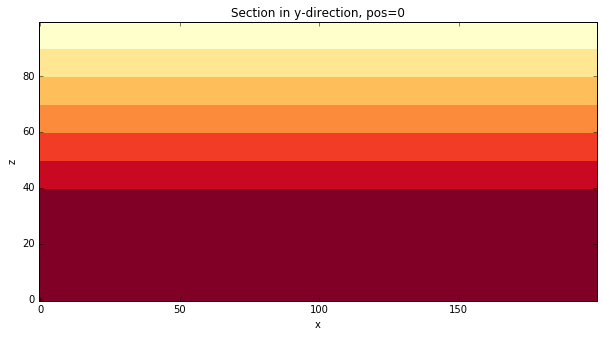

In [9]:
ex1.plot_section()

In [11]:
reload(pynoddy.history)
reload(pynoddy.events)
nm = pynoddy.history.NoddyHistory()
# add stratigraphy
strati_options = {'num_layers' : 8,
                  'layer_names' : ['layer 1', 'layer 2', 'layer 3',
                                   'layer 4', 'layer 5', 'layer 6', 
                                   'layer 7', 'layer 8'],
                  'layer_thickness' : [1500, 500, 500, 500, 500, 
                                       500, 500, 500]}
nm.add_event('stratigraphy', strati_options )

tilt_options = {'name' : 'Tilt',
                'pos' : (4000, 3500, 5000),
                'rotation' : 0.,
                'plunge_direction' : 0,
                'plunge' : 0.}

nm.add_event('tilt', tilt_options)

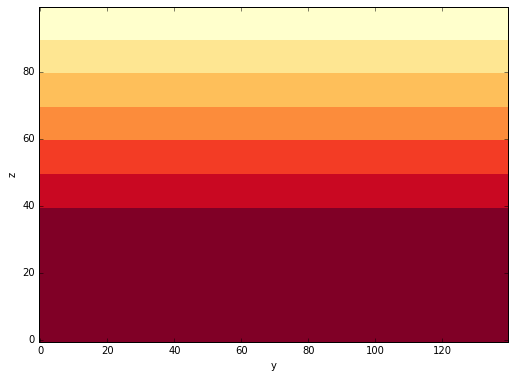

In [12]:

nm.write_history(history)
# Compute the model
reload(pynoddy)
pynoddy.compute_model(history, output_name) 
# Plot output
import pynoddy.output
reload(pynoddy.output)
nout = pynoddy.output.NoddyOutput(output_name)
nout.plot_section('x', layer_labels = strati_options['layer_names'][::-1], 
                  colorbar = True, title="",
                  savefig = False, fig_filename = "ex01_strati.eps")

In [13]:
ex1 = pynoddy.experiment.Experiment(history)

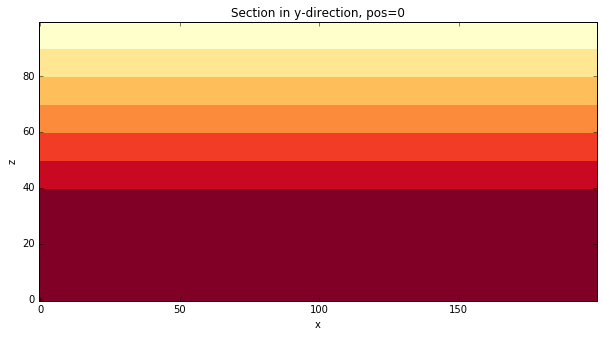

In [14]:
ex1.plot_section()

Adjust properties of tilt event:

In [15]:
ex1.events[2].properties['Rotation'] = 20.

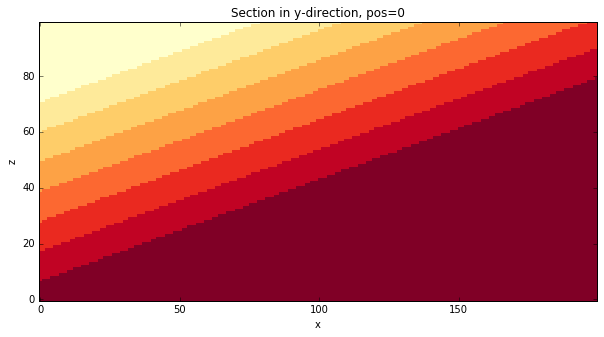

In [16]:
ex1.plot_section('y')

Now, we can define a stochastic variable for the tilt rotation:

First step: "freeze" current state as base model:

In [17]:
ex1.freeze()

This method stores the current events and properties in a "base_events" attribute which is not changed in the following experiments:

In [18]:
ex1.base_events[2].properties

{'Name': 'Tilt',
 'Plunge': 0.0,
 'Plunge Direction': 0.0,
 'Rotation': 20.0,
 'X': 4000.0,
 'Y': 3500.0,
 'Z': 5000.0}

Set random seed to ensure reproducibility:


In [19]:
ex1.set_random_seed(12345)

Define parameter distributions for stochastic properties:

In [20]:
param_stats = [{'event' : 2, 
              'parameter': 'Rotation',
              'stdev': 10.0,
              'type': 'normal'}
              ]

ex1.set_parameter_statistics(param_stats)

In [21]:
ex1.random_draw()

In [22]:
ex1.events[2].properties

{'Name': 'Tilt',
 'Plunge': 0.0,
 'Plunge Direction': 0.0,
 'Rotation': 17.95292340515287,
 'X': 4000.0,
 'Y': 3500.0,
 'Z': 5000.0}

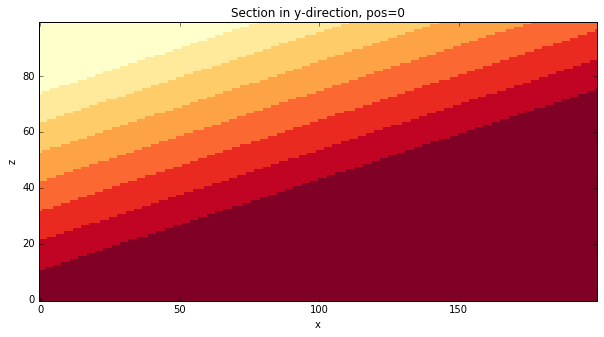

In [23]:
ex1.plot_section(colorbar=True, colorbar_orientation='horizontal')

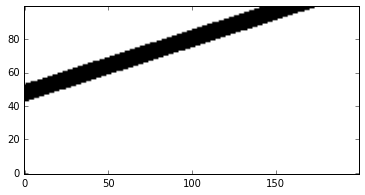

In [24]:
# extract only layer 4:
l4 = ex1.get_section('y').block[:,:,:] == 4
plt.imshow(l4[:,0,:].T, origin = 'lower left', cmap = 'gray_r')

Let's set up a simple uncertainty estimation from scratch:


In [25]:
# change resolution to increase simulation speed:
resolution = 100
ex1.change_cube_size(resolution)
# initialise output variable
tmp = ex1.get_section('y')
prob_4 = np.zeros_like(tmp.block[:,:,:])
n_draws = 1000

# now: generate random models and extract blocks of layer '4'
for i in range(n_draws):
    ex1.random_draw()
    tmp = ex1.get_section('y', resolution = resolution)
    prob_4 += (tmp.block[:,:,:] == 4)

# Normalise
prob_4 = prob_4 / float(n_draws)


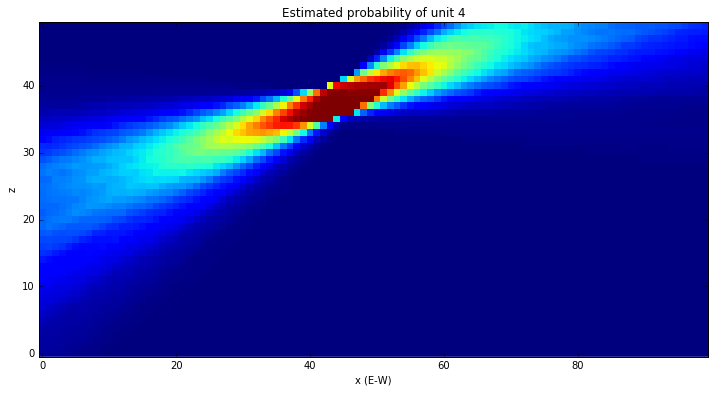

In [26]:
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
ax.imshow(prob_4.transpose()[:,0,:], 
           origin = 'lower left',
           interpolation = 'none')
plt.title("Estimated probability of unit 4")
plt.xlabel("x (E-W)")
plt.ylabel("z")

As a first test, we can now extract a 1-D profile:

In [ ]:
plt.plot(prob_4[20,:,:][0], np.arange(0,50,1))

Next step (homework for Alex): extract thickness and plot as histogram:

## Extract information at sampling lines

In [ ]:
reload(pynoddy.experiment)
ex1 = pynoddy.experiment.Experiment(history)

First step: add sampling line at a specified (x,y) location (note: default cube size: 1 m):

In [ ]:
ex1.add_sampling_line(2500, 3500)

Extract information at the position of the sampling line:

In [ ]:
plt.plot(ex1.get_model_lines(), np.arange(0,5000,1))

For comparison, see the complete model section:

In [ ]:
ex1.plot_section()

Homework 2 for Alex: extract value of one layer and generate statistics with dipping layers

## Change layer thickness

Next step: change layer thickness in pynoddy model

In [56]:
reload(pynoddy.history)
reload(pynoddy.events)
nm = pynoddy.history.NoddyHistory()
# add stratigraphy
strati_options = {'num_layers' : 8,
                  'layer_names' : ['layer 1', 'layer 2', 'layer 3',
                                   'layer 4', 'layer 5', 'layer 6', 
                                   'layer 7', 'layer 8'],
                  'layer_thickness' : [1500, 500, 500, 500, 500, 
                                       500, 500, 500]}
nm.add_event('stratigraphy', strati_options )

tilt_options = {'name' : 'Tilt',
                'pos' : (4000, 3500, 5000),
                'rotation' : 0.,
                'plunge_direction' : 0,
                'plunge' : 0.}

nm.add_event('tilt', tilt_options)

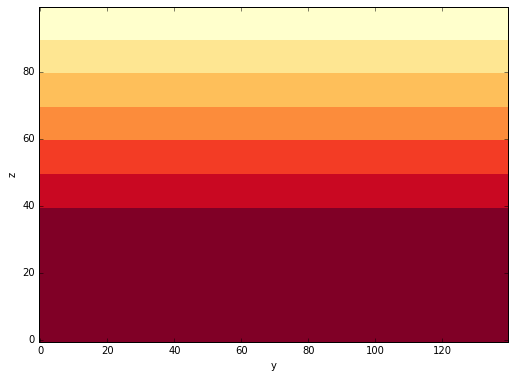

In [57]:

nm.write_history(history)
# Compute the model
reload(pynoddy)
pynoddy.compute_model(history, output_name) 
# Plot output
import pynoddy.output
reload(pynoddy.output)
nout = pynoddy.output.NoddyOutput(output_name)
nout.plot_section('x', layer_labels = strati_options['layer_names'][::-1], 
                  colorbar = True, title="",
                  savefig = False, fig_filename = "ex01_strati.eps")

Load history back and check possibility to adjust thicknesses:

In [184]:
reload(pynoddy.history)
reload(pynoddy.events)
history = 'simple_model.his'
nm = pynoddy.history.NoddyHistory(history)

In [185]:
history = "test.his"
nm.write_history(history)
# Compute the model
reload(pynoddy)
pynoddy.compute_model(history, output_name) 

''

In [170]:
strati.layers[-1].property_lines['Remanent Magnetization']

11

### Test change of layer thicknesses:

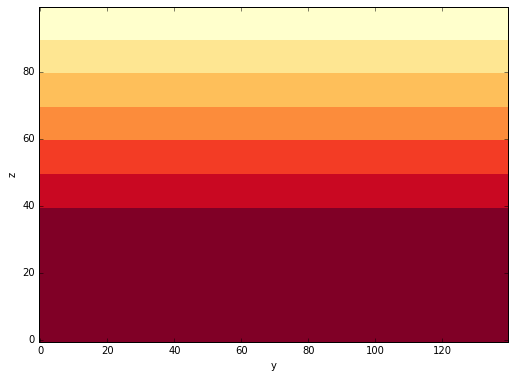

In [186]:
nout = pynoddy.output.NoddyOutput(output_name)
nout.plot_section('x', layer_labels = strati_options['layer_names'][::-1], 
                  colorbar = True, title="",
                  savefig = False, fig_filename = "ex01_strati.eps")

In [ ]:
reload(pynoddy.history)
reload(pynoddy.events)
history = 'simple_model.his'
nm = pynoddy.history.NoddyHistory(history)

Now: change height of one layer:

In [195]:
nm.events[1].layers[5].properties['Height'] = 4200.

In [196]:
nm.write_history(history)
# Compute the model
reload(pynoddy)
pynoddy.compute_model(history, output_name) 

''

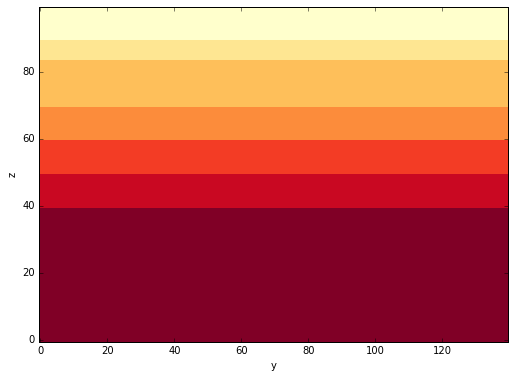

In [197]:
nout = pynoddy.output.NoddyOutput(output_name)
nout.plot_section('x', layer_labels = strati_options['layer_names'][::-1], 
                  colorbar = True, title="",
                  savefig = False, fig_filename = "ex01_strati.eps")

Yes, it works!! Only slightly strange point: defined is the layer "height" (with reference to the base level?), not the thickness! Anyway, good first start!